# Run 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import joblib
from pickle import dump
from pandas import read_csv
from pickle import load

%matplotlib inline

In [2]:
from astroquery.ned import Ned
import astropy.units as u
from astropy import coordinates
from astropy.table import Table
import time
from astropy.coordinates import SkyCoord

In [3]:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process.kernels import RBF

In [4]:
data_type = input('1: PCA\n 2: Scaled Data\n 3: Raw Data\n')

1: PCA
 2: Scaled Data
 3: Raw Data
1


# PCA & data scaling

In [5]:
df_training =  pd.read_csv("training_set_v1_dr7.csv")
columnsNamesArr = df_training.columns.values
column_names = list(columnsNamesArr)
print(column_names[1:])

['ra', 'dec', 'g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev', 'host_galaxy', 'distance', 'axis_ratio', 'category', 'radius', 'magnitude', 'u_mag', 'g_mag', 'i_mag', 'r_mag', 'z_mag', 'link']


In [6]:
print(df_training.groupby('category').size())


category
Contaminant       145
Known galaxies     18
dtype: int64


In [7]:
features = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev','axis_ratio','radius', 'magnitude']
print(len(features))

11


In [8]:
# classification as array of 0's and 1's
category = df_training['category']
classification = np.NaN*np.ones(len(category))
classification[category == 'Known galaxies'] = 1  
classification[category == 'Contaminant'] = 0 
print(len(classification))
print(len(classification[classification == 1]))

163
18


In [9]:
# define feature data and standardize it
data = df_training.loc[:,features].values
# define scaler
scaler = StandardScaler()
# scaler = RobustScaler()
# scaler = QuantileTransformer()
# fit scaler on the training dataset
scaler.fit(data)
# transform the training dataset
data_scaled = scaler.transform(data)

In [10]:
# transform data to 6 principle components which take into account 95 pct of the variance in the data
# pca = PCA(n_components = 11, random_state = 2020)
pca = PCA(n_components = 0.95, random_state = 2020) #this automatically chooses the amount of PC's for 95 pct variance
pca.fit(data_scaled)
principal_components = pca.transform(data_scaled)
principal_df = pd.DataFrame(data = principal_components, columns = ['Principal Component 1','Principal Component 2','Principal Component 3','Principal Component 4','Principal Component 5','Principal Component 6'])
final_df = pd.concat([principal_df, df_training[['category']]], axis = 1)


Text(0.5, 1.0, 'Influence on each principal component by features')

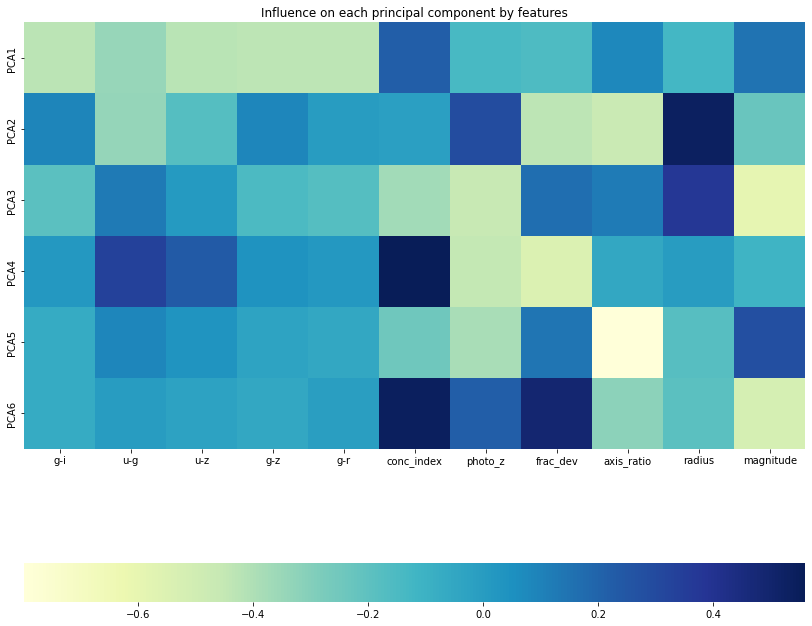

In [11]:
features_map = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'conc_index', 'photo_z', 'frac_dev', 'axis_ratio','radius', 'magnitude']
fig = plt.figure(figsize = (14,14))
ax = sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=features_map,
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
ax.set_title('Influence on each principal component by features')

In [12]:
X = principal_components
y = classification

In [13]:
if data_type == 1:
    X = principal_components
    y = classification
elif data_type == 2:
    X = data_scaled
    y = classification
elif data_type == 3:
    X = data
    y = classification

In [14]:
# X = data_scaled
# y = classification

In [15]:
# X = data
# y = classification

In [16]:
# scorign to balanced accuracy
# test svm and plot corner plots showing where its failing and iterate through individual contaminants
# add new corner plots for new 45 galaxy
# try rescaling radius to kpc

# Model training

In [17]:
clf = SVC(random_state = 2020,gamma='auto')
kfold = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
cv_results = cross_val_score(clf, X, y, cv=kfold, scoring='balanced_accuracy')
print('%f (%f)' % (cv_results.mean(), cv_results.std()))

0.941667 (0.072648)


In [18]:
clf.fit(X, y)
clf_predict = clf.predict(X)

In [19]:
# # Spot Check Algorithms
# random_state = 2020
# models = []
# models.append(('LR', LogisticRegression(random_state = 2020,solver='liblinear', multi_class='ovr')))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART',DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC(random_state = 2020,gamma='auto')))
# models.append(('GP', GaussianProcessClassifier(random_state = 2020)))
# models.append(('RF', RandomForestClassifier(random_state = 2020,max_depth=None, n_estimators=100, max_features= 'auto')))
# models.append(('MLP', MLPClassifier(random_state = 2020,activation='relu', solver='lbfgs', max_iter=200)))
# models.append(('PRCP', Perceptron(random_state = 2020, max_iter=30, tol = 0.001)))
# # evaluate each model in turn
# results = []
# names = []
# for name, model in models:
# 	kfold = StratifiedKFold(n_splits=4, random_state=2020, shuffle=True)
# 	cv_results = cross_val_score(model, X, y, cv=kfold, scoring='recall')
# 	results.append(cv_results)
# 	names.append(name)
# 	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# # try neural network

In [20]:
# # voting methods application
# clf1 = LogisticRegression(random_state = 2020,solver='liblinear', multi_class='ovr')
# clf2 = LinearDiscriminantAnalysis()
# clf3 = KNeighborsClassifier()
# clf4 = DecisionTreeClassifier()
# clf5 = GaussianNB()
# clf6 = GaussianProcessClassifier(random_state = 2020)
# clf7 = SVC(random_state = 2020,gamma='auto')
# clf8 = RandomForestClassifier(random_state = 2020,max_depth=None, n_estimators=100, max_features= 'auto')
# clf9 = MLPClassifier(random_state = 2020, activation='relu', solver='lbfgs', max_iter=100000)
# clf10 = Perceptron(random_state = 2020, max_iter=30, tol = 0.001)

# eclf1 = VotingClassifier(estimators=[('SVM', clf7),('LR',clf1),('CART', clf4), ('GP', clf6), ('MLP', clf9), ('LDA',clf2)], voting='hard')
# eclf1.fit(X, y)
# eclf_predict = eclf1.predict(X)

In [21]:
# # save the model
# dump(eclf1, open('voting_model_PCA_v1_dr7.pkl', 'wb'))
# # save the scaler
# dump(scaler, open('scaler_voting_model_PCA_v1_dr7.pkl', 'wb'))
# # save the pca
# dump(pca, open('pca_model_PCA_v1_dr7.pkl', 'wb'))

In [22]:
plt.rcParams.update({'font.size': 20})

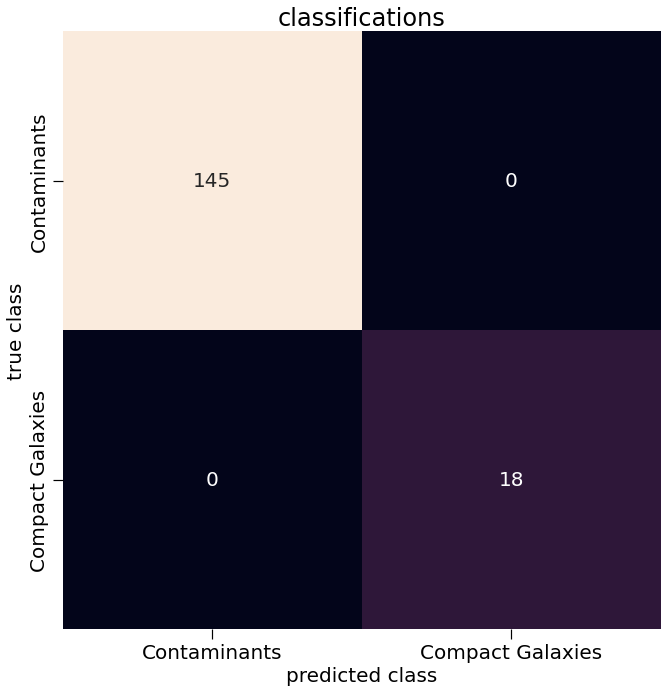

In [23]:
fig1 = plt.figure(figsize=(11,11))
g = sns.heatmap(confusion_matrix(y, clf_predict), square=True, annot=True, fmt="d", cbar=False, xticklabels=['Contaminants', 'Compact Galaxies'], yticklabels=['Contaminants', 'Compact Galaxies'])
g.set_yticklabels(labels=g.get_yticklabels(), va='center')
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.title('classifications')
plt.tick_params('both', length=10, width=1.2, which='major', labelsize=20)

# Model application on Atlas3D galaxies

In [24]:
df_atlas3d = pd.read_csv("atlas3d_search_dr7.csv")
columnsNamesArr = df_atlas3d.columns.values
column_names = list(columnsNamesArr)
print(column_names[1:])

['objid', 'ra', 'dec', 'g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev', 'host_galaxy', 'distance', 'axis_ratio', 'category', 'radius', 'magnitude', 'u_mag', 'g_mag', 'i_mag', 'r_mag', 'z_mag', 'link']


In [25]:
objid = df_atlas3d['objid']
ra, dec = df_atlas3d['ra'], df_atlas3d['dec']
host_galaxy = df_atlas3d['host_galaxy']
distance = df_atlas3d['distance']
magnitude = df_atlas3d['magnitude']
category = df_atlas3d['category']
radius = df_atlas3d['radius']
u_mag, g_mag, r_mag, i_mag, z_mag = df_atlas3d['u_mag'], df_atlas3d['g_mag'], df_atlas3d['r_mag'], df_atlas3d['i_mag'], df_atlas3d['z_mag']
concentration_index = df_atlas3d['concentration_index']
frac_dev = df_atlas3d['frac_dev']
axis_ratio = df_atlas3d['axis_ratio']
photoz = df_atlas3d['photo_z']
category = df_atlas3d['category']
g_i, u_g, u_z, g_z, g_r = df_atlas3d['g-i'], df_atlas3d['u-g'], df_atlas3d['u-z'], df_atlas3d['g-z'], df_atlas3d['g-r']
magnitude = df_atlas3d['magnitude']
radius = df_atlas3d['radius']

In [26]:
category[category == 'Possible contaminants'] = 'Possible compact galaxies'

C:\Users\Home\AppData\Local\Temp/ipykernel_10536/2455194359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category[category == 'Possible contaminants'] = 'Possible compact galaxies'


In [27]:
features = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev','axis_ratio','radius', 'magnitude']
print(len(features))

11


In [28]:
#make a link to sdss for this object
objid = np.array(objid)
link = []
for i in range(len(objid)):
    url = 'http://cas.sdss.org/dr7/en/tools/explore/obj.asp?id=' + str(objid[i])
    link.append(url)
link = np.array(link)

In [29]:
print(df_atlas3d.groupby('category').size())

category
Known galaxies                  18
Possible compact galaxies    18769
dtype: int64


In [30]:
#PCA
X = df_atlas3d.loc[:,features].values
X_scaled = scaler.transform(X)
X_pca_scaled = pca.transform(X_scaled)
y = clf.predict(X_pca_scaled) 

In [31]:
# #Scaled
# X = df_atlas3d.loc[:,features].values
# X_scaled = scaler.transform(X)
# # X_pca_scaled = pca.transform(X_scaled)
# y = eclf1.predict(X_scaled) 

In [32]:
# #Raw
# X = df_atlas3d.loc[:,features].values
# # X_scaled = scaler.transform(X)
# # X_pca_scaled = pca.transform(X_scaled)
# y = eclf1.predict(X) 

In [33]:
index_1a = np.where(y == 1)[0]
print('Voting method:', len(index_1a))
index_1b = np.where(y == 0)[0]

Voting method: 513


In [34]:
# dictionary of lists  
dict = {'objid': objid[index_1a], 'ra': ra[index_1a], 'dec': dec[index_1a], 'g-i': g_mag[index_1a] - i_mag[index_1a], 'u-g': u_mag[index_1a] - g_mag[index_1a], 'u-z': u_mag[index_1a] - z_mag[index_1a], 'g-z': g_mag[index_1a] - z_mag[index_1a], 'g-r': g_mag[index_1a] - r_mag[index_1a], 'concentration_index': concentration_index[index_1a], 'photo_z': photoz[index_1a], 'frac_dev': frac_dev[index_1a], 'host_galaxy': host_galaxy[index_1a], 'distance': distance[index_1a], 'axis_ratio': axis_ratio[index_1a], 'category': category[index_1a], 'radius': radius[index_1a], 'magnitude': magnitude[index_1a], 'u_mag': u_mag[index_1a], 'g_mag': g_mag[index_1a], 'i_mag': i_mag[index_1a], 'r_mag': r_mag[index_1a], 'z_mag': z_mag[index_1a],  'link': link[index_1a]}   
df_voting_results= pd.DataFrame(dict) 
    
# saving the dataframe 
df_voting_results.to_csv('test_svm_results_v1.csv',index = False) 

In [35]:
print(df_voting_results.groupby('category').size())
print('From a total of 871 host galaxies')

category
Known galaxies                18
Possible compact galaxies    495
dtype: int64
From a total of 871 host galaxies


# NED search for possible compact galaxies from 

In [36]:
objid_voting = df_voting_results['objid']
ra_voting, dec_voting = np.array(df_voting_results['ra']), np.array(df_voting_results['dec'])
host_galaxy_voting = df_voting_results['host_galaxy']
distance_voting = df_voting_results['distance']
magnitude_voting = df_voting_results['magnitude']
category_voting = df_voting_results['category']
radius_voting = df_voting_results['radius']
u_mag_voting, g_mag_voting, r_mag_voting, i_mag_voting, z_mag_voting = df_voting_results['u_mag'], df_voting_results['g_mag'], df_voting_results['r_mag'], df_voting_results['i_mag'], df_voting_results['z_mag']
concentration_index_voting = df_voting_results['concentration_index']
frac_dev_voting = df_voting_results['frac_dev']
axis_ratio_voting = df_voting_results['axis_ratio']
photoz_voting = df_voting_results['photo_z']
category_voting = df_voting_results['category']
g_i_voting, u_g_voting, u_z_voting, g_z_voting, g_r_voting = df_voting_results['g-i'], df_voting_results['u-g'], df_voting_results['u-z'], df_voting_results['g-z'], df_voting_results['g-r']
link_voting = df_voting_results['link']

In [37]:
name1 = []
ra1 = []
dec1 = []
velocity1 = []
redshift1 = []
flag1 = []
for i in range(len(ra_voting)):
    print(i)
#     if i%200 == 0:
#         time.sleep(15)
    co = coordinates.SkyCoord(ra=ra_voting[i], dec=dec_voting[i], unit=(u.deg, u.deg))
    results = Ned.query_region(co, radius=1* u.arcsec, equinox='J2000.0')
    if len(results) == 0:
        name1_temp, ra1_temp, dec1_temp, vel1_temp, redshift1_temp, flag1_temp = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        name1.append(name1_temp)
        ra1.append(ra1_temp)
        dec1.append(dec1_temp)
        velocity1.append(vel1_temp)
        redshift1.append(redshift1_temp)
        flag1.append(flag1_temp)
    else:
        name1_temp, ra1_temp, dec1_temp, vel1_temp, redshift1_temp, flag1_temp = results['Object Name'], results['RA'], results['DEC'], results['Velocity'], results['Redshift'], results['Redshift Flag']
        for j in range(len(name1_temp)):
            name1.append(name1_temp[j])
            ra1.append(ra1_temp[j])
            dec1.append(dec1_temp[j])
            velocity1.append(vel1_temp[j])
            redshift1.append(redshift1_temp[j])
            flag1.append(flag1_temp[j])

0
1
2
3
4
5
6
7


8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


56
57
58
59
60
61
62
63
64
65
66
67
68


69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102


103
104
105
106
107
108
109
110
111
112
113
114
115
116


117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172


173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208


209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227


228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244


WARNING

245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261

: AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead. [astroquery.ned.core]



262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295


296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315


316
317
318
319
320
321
322
323
324
325
326
327
328
329


330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348


349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367


368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384


385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403


404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419


WARNING

420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439


: AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead. [astroquery.ned.core]


440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459


460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478


479
480
481
482
483
484
485
486
487
488
489
490
491


492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512


In [38]:
# dictionary of lists  
dict = {'name': name1, 'ra': ra1, 'dec': dec1, 'velocity': velocity1, 'redshift': redshift1, 'flag': flag1}  
df_ned_voting = pd.DataFrame(dict) 
    
# saving the dataframe 
# df1.to_csv('ned_compact_dr7.csv') 

# NED (with specz > 0.01) and ML results crossmatching

In [39]:
ra_ned_voting, dec_ned_voting, name_ned_voting, velocity_ned_voting, redshift_ned_voting, flag_ned_voting = df_ned_voting['ra'], df_ned_voting['dec'], df_ned_voting['name'], df_ned_voting['velocity'], df_ned_voting['redshift'], df_ned_voting['flag']

In [40]:
redshift_ned_voting_1a = redshift_ned_voting.copy()
redshift_ned_voting_1a[redshift_ned_voting_1a == '--'] = np.nan
redshift_ned_voting_1a = redshift_ned_voting_1a.astype(float)

voting_specz_over = (redshift_ned_voting_1a > 0.01) & (flag_ned_voting == 'SPEC')

C:\Users\Home\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1201: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [41]:
ra_ned_voting_1 = np.array(ra_ned_voting[voting_specz_over])
dec_ned_voting_1 = np.array(dec_ned_voting[voting_specz_over])
name_ned_voting_1 =  np.array(name_ned_voting[voting_specz_over])
velocity_ned_voting_1 = np.array(velocity_ned_voting[voting_specz_over])
redshift_ned_voting_1 = np.array(redshift_ned_voting[voting_specz_over]).astype(float)
flag_ned_voting_1 = np.array(flag_ned_voting[voting_specz_over])

In [42]:
c1 = SkyCoord(ra=ra_voting*u.degree, dec=dec_voting*u.degree)
catalog1 = SkyCoord(ra=ra_ned_voting_1*u.degree, dec=dec_ned_voting_1*u.degree)
idx_1, d2d_1, d3d_1 = c1.match_to_catalog_sky(catalog1)

In [43]:
max_sep = 1 * u.arcsec
sep_constraint_1 = d2d_1 < max_sep
c1_matches = c1[sep_constraint_1]
catalog1_matches = catalog1[idx_1[sep_constraint_1]]

In [44]:
objid_training = df_training['objid']
ra_training, dec_training = df_training['ra'], df_training['dec']
host_galaxy_training = df_training['host_galaxy']
distance_training = df_training['distance']
magnitude_training = df_training['magnitude']
category_training = df_training['category']
radius_training = df_training['radius']
u_mag_training, g_mag_training, r_mag_training, i_mag_training, z_mag_training = df_training['u_mag'], df_training['g_mag'], df_training['r_mag'], df_training['i_mag'], df_training['z_mag']
concentration_index_training = df_training['concentration_index']
frac_dev_training = df_training['frac_dev']
axis_ratio_training = df_training['axis_ratio']
photoz_training = df_training['photo_z']
category_training = df_training['category']
g_i_training, u_g_training, u_z_training, g_z_training, g_r_training = df_training['g-i'], df_training['u-g'], df_training['u-z'], df_training['g-z'], df_training['g-r']
link_training = df_training['link']

In [45]:
category_voting[sep_constraint_1] = 'New Contaminant'

C:\Users\Home\AppData\Local\Temp/ipykernel_10536/2405184457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_voting[sep_constraint_1] = 'New Contaminant'


In [46]:
print(category_training[np.where(category_training =='Known galaxies')[0]])

0     Known galaxies
1     Known galaxies
2     Known galaxies
3     Known galaxies
4     Known galaxies
5     Known galaxies
6     Known galaxies
7     Known galaxies
8     Known galaxies
9     Known galaxies
10    Known galaxies
11    Known galaxies
12    Known galaxies
13    Known galaxies
14    Known galaxies
15    Known galaxies
16    Known galaxies
17    Known galaxies
Name: category, dtype: object


# Creating new training data:
## Adding original training set + NED confirmed contaminants

In [47]:
# objid_final = np.concatenate((objid_training,objid_voting[sep_constraint_1]))
# ra_final, dec_final = np.concatenate((ra_training,ra_voting[sep_constraint_1])), np.concatenate((dec_training,dec_voting[sep_constraint_1]))
# host_galaxy_final = np.concatenate((host_galaxy_training,host_galaxy_voting[sep_constraint_1]))
# distance_final = np.concatenate((distance_training,distance_voting[sep_constraint_1]))
# magnitude_final = np.concatenate((magnitude_training,magnitude_voting[sep_constraint_1]))
# category_final = np.concatenate((category_training,category_voting[sep_constraint_1]))
# radius_final = np.concatenate((radius_training,radius_voting[sep_constraint_1]))
# u_mag_final, g_mag_final, r_mag_final, i_mag_final, z_mag_final = np.concatenate((u_mag_training,u_mag_voting[sep_constraint_1])), np.concatenate((g_mag_training,g_mag_voting[sep_constraint_1])), np.concatenate((r_mag_training,r_mag_voting[sep_constraint_1])), np.concatenate((i_mag_training,i_mag_voting[sep_constraint_1])), np.concatenate((z_mag_training,z_mag_voting[sep_constraint_1]))
# concentration_index_final = np.concatenate((concentration_index_training,concentration_index_voting[sep_constraint_1]))
# frac_dev_final = np.concatenate((frac_dev_training,frac_dev_voting[sep_constraint_1]))
# axis_ratio_final = np.concatenate((axis_ratio_training,axis_ratio_voting[sep_constraint_1]))
# photoz_final = np.concatenate((photoz_training,photoz_voting[sep_constraint_1]))
# g_i_final, u_g_final, u_z_final, g_z_final, g_r_final = np.concatenate((g_i_training,g_i_voting[sep_constraint_1])), np.concatenate((u_g_training,u_g_voting[sep_constraint_1])), np.concatenate((u_z_training,u_z_voting[sep_constraint_1])), np.concatenate((g_z_training,g_z_voting[sep_constraint_1])), np.concatenate((g_r_training,g_r_voting[sep_constraint_1]))
# link_final = np.concatenate((link_training,link_voting[sep_constraint_1]))

In [48]:
# print(category_voting[sep_constraint_1])

In [49]:
# # dictionary of lists  
# dict = {'objid': objid_final, 'ra': ra_final, 'dec': dec_final, 'g-i': g_i_final, 'u-g': u_g_final, 'u-z': u_z_final, 'g-z': g_z_final, 'g-r': g_r_final, 'concentration_index': concentration_index_final, 'photo_z': photoz_final, 'frac_dev': frac_dev_final, 'host_galaxy': host_galaxy_final, 'distance': distance_final, 'axis_ratio': axis_ratio_final, 'category': category_final, 'radius': radius_final, 'magnitude': magnitude_final, 'u_mag': u_mag_final, 'g_mag': g_mag_final, 'i_mag': i_mag_final, 'r_mag': r_mag_final, 'z_mag': z_mag_final,  'link': link_final}  
# df_training_v2 = pd.DataFrame(dict) 
    
# # saving the dataframe 
# df_training_v2.to_csv('test_training_v2_dr7.csv') 

# Creating new training data:
## Confirmed compact galaxies + Ned contaminants only

In [50]:
objid_final = np.concatenate((objid_training[np.where(category_training =='Known galaxies')[0]],objid_voting[sep_constraint_1]))
ra_final, dec_final = np.concatenate((ra_training[np.where(category_training =='Known galaxies')[0]],ra_voting[sep_constraint_1])), np.concatenate((dec_training[np.where(category_training =='Known galaxies')[0]],dec_voting[sep_constraint_1]))
host_galaxy_final = np.concatenate((host_galaxy_training[np.where(category_training =='Known galaxies')[0]],host_galaxy_voting[sep_constraint_1]))
distance_final = np.concatenate((distance_training[np.where(category_training =='Known galaxies')[0]],distance_voting[sep_constraint_1]))
magnitude_final = np.concatenate((magnitude_training[np.where(category_training =='Known galaxies')[0]],magnitude_voting[sep_constraint_1]))
category_final = np.concatenate((category_training[np.where(category_training =='Known galaxies')[0]],category_voting[sep_constraint_1]))
radius_final = np.concatenate((radius_training[np.where(category_training =='Known galaxies')[0]],radius_voting[sep_constraint_1]))
u_mag_final, g_mag_final, r_mag_final, i_mag_final, z_mag_final = np.concatenate((u_mag_training[np.where(category_training =='Known galaxies')[0]],u_mag_voting[sep_constraint_1])), np.concatenate((g_mag_training[np.where(category_training =='Known galaxies')[0]],g_mag_voting[sep_constraint_1])), np.concatenate((r_mag_training[np.where(category_training =='Known galaxies')[0]],r_mag_voting[sep_constraint_1])), np.concatenate((i_mag_training[np.where(category_training =='Known galaxies')[0]],i_mag_voting[sep_constraint_1])), np.concatenate((z_mag_training[np.where(category_training =='Known galaxies')[0]],z_mag_voting[sep_constraint_1]))
concentration_index_final = np.concatenate((concentration_index_training[np.where(category_training =='Known galaxies')[0]],concentration_index_voting[sep_constraint_1]))
frac_dev_final = np.concatenate((frac_dev_training[np.where(category_training =='Known galaxies')[0]],frac_dev_voting[sep_constraint_1]))
axis_ratio_final = np.concatenate((axis_ratio_training[np.where(category_training =='Known galaxies')[0]],axis_ratio_voting[sep_constraint_1]))
photoz_final = np.concatenate((photoz_training[np.where(category_training =='Known galaxies')[0]],photoz_voting[sep_constraint_1]))
g_i_final, u_g_final, u_z_final, g_z_final, g_r_final = np.concatenate((g_i_training[np.where(category_training =='Known galaxies')[0]],g_i_voting[sep_constraint_1])), np.concatenate((u_g_training[np.where(category_training =='Known galaxies')[0]],u_g_voting[sep_constraint_1])), np.concatenate((u_z_training[np.where(category_training =='Known galaxies')[0]],u_z_voting[sep_constraint_1])), np.concatenate((g_z_training[np.where(category_training =='Known galaxies')[0]],g_z_voting[sep_constraint_1])), np.concatenate((g_r_training[np.where(category_training =='Known galaxies')[0]],g_r_voting[sep_constraint_1]))
link_final = np.concatenate((link_training[np.where(category_training =='Known galaxies')[0]],link_voting[sep_constraint_1]))

In [51]:
# dictionary of lists  
dict = {'objid': objid_final, 'ra': ra_final, 'dec': dec_final, 'g-i': g_i_final, 'u-g': u_g_final, 'u-z': u_z_final, 'g-z': g_z_final, 'g-r': g_r_final, 'concentration_index': concentration_index_final, 'photo_z': photoz_final, 'frac_dev': frac_dev_final, 'host_galaxy': host_galaxy_final, 'distance': distance_final, 'axis_ratio': axis_ratio_final, 'category': category_final, 'radius': radius_final, 'magnitude': magnitude_final, 'u_mag': u_mag_final, 'g_mag': g_mag_final, 'i_mag': i_mag_final, 'r_mag': r_mag_final, 'z_mag': z_mag_final,  'link': link_final}  
df_training_v2 = pd.DataFrame(dict) 
    
# saving the dataframe 
df_training_v2.to_csv('svm_training_set_smaller_dr7.csv') 

In [52]:
print(df_training_v2)

                  objid          ra        dec       g-i       u-g       u-z  \
0    588017703470694575  187.739089  12.429029  1.219089  1.997750  3.501635   
1    588017566564745396  187.882050  12.691777  0.918632  1.579510  2.654173   
2    588017702933758107  187.583501  11.921879  0.939611  1.517237  2.646874   
3    588017566027939963  187.970408  12.266407  0.986498  1.615053  2.807095   
4    588017566564679738  187.633203  12.490171  1.232374  1.939530  3.480027   
..                  ...         ...        ...       ...       ...       ...   
116  587736545776566655  230.463887   4.723648  1.175365  1.729107  3.209720   
117  587741723356758152  184.936200  28.614601  1.152414  1.717359  3.171761   
118  587731500795429094  151.356477  53.166041  1.190658  1.853744  3.323479   
119  587731500795560070  151.765457  53.399852  1.119002  1.742824  3.129990   
120  588017604691493043  207.444129  42.601847  1.233641  1.902857  3.442179   

          g-z       g-r  concentration_

In [72]:
# dictionary of lists  
for nn in range(len(objid_voting[sep_constraint_1])):
#     dict = {'objid': objid_final[:len(objid_training)+nn], 'ra': ra_final[:len(objid_training)+nn], 'dec': dec_final[:len(objid_training)+nn], 'g-i': g_i_final[:len(objid_training)+nn], 'u-g': u_g_final[:len(objid_training)+nn], 'u-z': u_z_final[:len(objid_training)+nn], 'g-z': g_z_final[:len(objid_training)+nn], 'g-r': g_r_final[:len(objid_training)+nn], 'concentration_index': concentration_index_final[:len(objid_training)+nn], 'photo_z': photoz_final[:len(objid_training)+nn], 'frac_dev': frac_dev_final[:len(objid_training)+nn], 'host_galaxy': host_galaxy_final[:len(objid_training)+nn], 'distance': distance_final[:len(objid_training)+nn], 'axis_ratio': axis_ratio_final[:len(objid_training)+nn], 'category': category_final[:len(objid_training)+nn], 'radius': radius_final[:len(objid_training)+nn], 'magnitude': magnitude_final[:len(objid_training)+nn], 'u_mag': u_mag_final[:len(objid_training)+nn], 'g_mag': g_mag_final[:len(objid_training)+nn], 'i_mag': i_mag_final[:len(objid_training)+nn], 'r_mag': r_mag_final[:len(objid_training)+nn], 'z_mag': z_mag_final[:len(objid_training)+nn],  'link': link_final[:len(objid_training)+nn]}  
    dict = {'objid': objid_final[:35+nn], 'ra': ra_final[:35+nn], 'dec': dec_final[:35+nn], 'g-i': g_i_final[:35+nn], 'u-g': u_g_final[:35+nn], 'u-z': u_z_final[:35+nn], 'g-z': g_z_final[:35+nn], 'g-r': g_r_final[:35+nn], 'concentration_index': concentration_index_final[:35+nn], 'photo_z': photoz_final[:35+nn], 'frac_dev': frac_dev_final[:35+nn], 'host_galaxy': host_galaxy_final[:35+nn], 'distance': distance_final[:35+nn], 'axis_ratio': axis_ratio_final[:35+nn], 'category': category_final[:35+nn], 'radius': radius_final[:35+nn], 'magnitude': magnitude_final[:35+nn], 'u_mag': u_mag_final[:35+nn], 'g_mag': g_mag_final[:35+nn], 'i_mag': i_mag_final[:35+nn], 'r_mag': r_mag_final[:35+nn], 'z_mag': z_mag_final[:35+nn],  'link': link_final[:35+nn]}  
    df_training_v2 = pd.DataFrame(dict) 
    print(df_training_v2 .groupby('category').size())
    # classification as array of 0's and 1's
    category = df_training_v2['category']
    classification = np.NaN*np.ones(len(category))
    classification[category == 'Known galaxies'] = 1  
    classification[(category == 'Contaminant') | (category == 'New Contaminant')] = 0 
    print('Total:',len(classification))
    print('Known:',len(classification[classification == 1]))
    # define feature data and standardize it
    data = df_training_v2.loc[:,features].values
    # define scaler
#     scaler = StandardScaler()
    scaler = RobustScaler()
    # scaler = QuantileTransformer()
    # fit scaler on the training dataset
    scaler.fit(data)
    # transform the training dataset
    data_scaled = scaler.transform(data)
    # transform data to 6 principle components which take into account 95 pct of the variance in the data
    pca = PCA(n_components = 6, random_state = 2020)
    pca.fit(data_scaled)
    # pca = PCA(n_components = 0.95, random_state = 2020) this automatically chooses the amount of PC's for 95 pct variance
    principal_components = pca.transform(data_scaled)
    principal_df = pd.DataFrame(data = principal_components, columns = ['Principal Component 1','Principal Component 2','Principal Component 3','Principal Component 4','Principal Component 5','Principal Component 6'])
    final_df = pd.concat([principal_df, df_training[['category']]], axis = 1)
    X = principal_components
    y = classification
#     clf = SVC(random_state = 2020,gamma='auto')
# #     clf = MLPClassifier(random_state = 2020, activation='relu', solver='lbfgs', max_iter=100000)
#     kfold = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
#     cv_results = cross_val_score(clf, X, y, cv=kfold, scoring='balanced_accuracy')
#     print('%f (%f)' % (cv_results.mean(), cv_results.std()))
# Spot Check Algorithms
    random_state = 2020
    models = []
    models.append(('LR', LogisticRegression(random_state = 2020,solver='liblinear', multi_class='ovr')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART',DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(random_state = 2020,gamma='auto')))
    models.append(('GP', GaussianProcessClassifier(random_state = 2020)))
    models.append(('RF', RandomForestClassifier(random_state = 2020,max_depth=None, n_estimators=100, max_features= 'auto')))
    models.append(('MLP', MLPClassifier(random_state = 2020,hidden_layer_sizes=(150,100,50),activation='relu', solver='lbfgs', max_iter=200)))
    models.append(('PRCP', Perceptron(random_state = 2020, max_iter=30, tol = 0.001)))
    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='recall')
        results.append(cv_results)
        names.append(name)
        print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


category
Known galaxies     18
New Contaminant    17
dtype: int64
Total: 35
Known: 18
LR: 0.666667 (0.229734)
LDA: 0.733333 (0.275882)
KNN: 0.483333 (0.152753)
CART: 0.700000 (0.214735)
NB: 0.650000 (0.226078)
SVM: 0.666667 (0.278887)
GP: 0.600000 (0.226078)
RF: 0.800000 (0.266667)
MLP: 0.583333 (0.258199)
PRCP: 0.566667 (0.355121)
category
Known galaxies     18
New Contaminant    18
dtype: int64
Total: 36
Known: 18
LR: 0.500000 (0.190029)
LDA: 0.733333 (0.275882)
KNN: 0.433333 (0.177951)
CART: 0.700000 (0.214735)
NB: 0.533333 (0.291548)
SVM: 0.500000 (0.190029)
GP: 0.483333 (0.270801)
RF: 0.766667 (0.122474)
MLP: 0.600000 (0.226078)
PRCP: 0.466667 (0.359784)
category
Known galaxies     18
New Contaminant    19
dtype: int64
Total: 37
Known: 18
LR: 0.566667 (0.177951)
LDA: 0.566667 (0.177951)
KNN: 0.333333 (0.091287)
CART: 0.633333 (0.305505)
NB: 0.666667 (0.241523)
SVM: 0.600000 (0.275882)
GP: 0.533333 (0.291548)
RF: 0.550000 (0.266667)
MLP: 0.583333 (0.258199)
PRCP: 0.650000 (0.339116

RF: 0.500000 (0.105409)
MLP: 0.550000 (0.266667)
PRCP: 0.766667 (0.290593)
category
Known galaxies     18
New Contaminant    42
dtype: int64
Total: 60
Known: 18
LR: 0.533333 (0.281859)
LDA: 0.583333 (0.247207)
KNN: 0.216667 (0.113039)
CART: 0.533333 (0.281859)
NB: 0.450000 (0.145297)
SVM: 0.216667 (0.113039)
GP: 0.450000 (0.214735)
RF: 0.450000 (0.145297)
MLP: 0.550000 (0.266667)
PRCP: 0.650000 (0.300000)
category
Known galaxies     18
New Contaminant    43
dtype: int64
Total: 61
Known: 18
LR: 0.533333 (0.281859)
LDA: 0.583333 (0.247207)
KNN: 0.216667 (0.113039)
CART: 0.566667 (0.275882)
NB: 0.500000 (0.190029)
SVM: 0.283333 (0.040825)
GP: 0.383333 (0.187083)
RF: 0.333333 (0.091287)
MLP: 0.500000 (0.190029)
PRCP: 0.600000 (0.406202)
category
Known galaxies     18
New Contaminant    44
dtype: int64
Total: 62
Known: 18
LR: 0.533333 (0.281859)
LDA: 0.583333 (0.247207)
KNN: 0.283333 (0.040825)
CART: 0.383333 (0.281859)
NB: 0.400000 (0.161589)
SVM: 0.283333 (0.040825)
GP: 0.333333 (0.091287

RF: 0.216667 (0.113039)
MLP: 0.600000 (0.161589)
PRCP: 0.266667 (0.161589)
category
Known galaxies     18
New Contaminant    67
dtype: int64
Total: 85
Known: 18
LR: 0.283333 (0.040825)
LDA: 0.400000 (0.161589)
KNN: 0.050000 (0.100000)
CART: 0.383333 (0.100000)
NB: 0.266667 (0.161589)
SVM: 0.166667 (0.139443)
GP: 0.283333 (0.040825)
RF: 0.316667 (0.185592)
MLP: 0.616667 (0.100000)
PRCP: 0.466667 (0.187083)
category
Known galaxies     18
New Contaminant    68
dtype: int64
Total: 86
Known: 18
LR: 0.283333 (0.040825)
LDA: 0.383333 (0.100000)
KNN: 0.050000 (0.100000)
CART: 0.350000 (0.300000)
NB: 0.266667 (0.161589)
SVM: 0.166667 (0.139443)
GP: 0.283333 (0.040825)
RF: 0.366667 (0.194365)
MLP: 0.450000 (0.145297)
PRCP: 0.450000 (0.367423)
category
Known galaxies     18
New Contaminant    69
dtype: int64
Total: 87
Known: 18
LR: 0.283333 (0.040825)
LDA: 0.333333 (0.091287)
KNN: 0.050000 (0.100000)
CART: 0.483333 (0.219848)
NB: 0.266667 (0.161589)
SVM: 0.166667 (0.139443)
GP: 0.283333 (0.040825

RF: 0.166667 (0.139443)
MLP: 0.450000 (0.145297)
PRCP: 0.516667 (0.304594)
category
Known galaxies     18
New Contaminant    92
dtype: int64
Total: 110
Known: 18
LR: 0.216667 (0.113039)
LDA: 0.350000 (0.161589)
KNN: 0.100000 (0.122474)
CART: 0.216667 (0.113039)
NB: 0.283333 (0.040825)
SVM: 0.116667 (0.145297)
GP: 0.283333 (0.040825)
RF: 0.216667 (0.113039)
MLP: 0.450000 (0.145297)
PRCP: 0.450000 (0.145297)
category
Known galaxies     18
New Contaminant    93
dtype: int64
Total: 111
Known: 18
LR: 0.283333 (0.040825)
LDA: 0.283333 (0.040825)
KNN: 0.100000 (0.122474)
CART: 0.383333 (0.100000)
NB: 0.333333 (0.091287)
SVM: 0.166667 (0.139443)
GP: 0.283333 (0.040825)
RF: 0.283333 (0.040825)
MLP: 0.500000 (0.353553)
PRCP: 0.400000 (0.161589)
category
Known galaxies     18
New Contaminant    94
dtype: int64
Total: 112
Known: 18
LR: 0.283333 (0.040825)
LDA: 0.416667 (0.293447)
KNN: 0.100000 (0.122474)
CART: 0.316667 (0.185592)
NB: 0.333333 (0.091287)
SVM: 0.166667 (0.139443)
GP: 0.283333 (0.040

RF: 0.283333 (0.040825)
MLP: 0.500000 (0.353553)
PRCP: 0.216667 (0.194365)
category
Known galaxies      18
New Contaminant    103
dtype: int64
Total: 121
Known: 18
LR: 0.283333 (0.040825)
LDA: 0.283333 (0.040825)
KNN: 0.100000 (0.122474)
CART: 0.216667 (0.113039)
NB: 0.283333 (0.040825)
SVM: 0.116667 (0.145297)
GP: 0.283333 (0.040825)
RF: 0.283333 (0.040825)
MLP: 0.500000 (0.353553)
PRCP: 0.216667 (0.194365)
category
Known galaxies      18
New Contaminant    103
dtype: int64
Total: 121
Known: 18
LR: 0.283333 (0.040825)
LDA: 0.283333 (0.040825)
KNN: 0.100000 (0.122474)
CART: 0.300000 (0.291548)
NB: 0.283333 (0.040825)
SVM: 0.116667 (0.145297)
GP: 0.283333 (0.040825)
RF: 0.283333 (0.040825)
MLP: 0.500000 (0.353553)
PRCP: 0.216667 (0.194365)
category
Known galaxies      18
New Contaminant    103
dtype: int64
Total: 121
Known: 18
LR: 0.283333 (0.040825)
LDA: 0.283333 (0.040825)
KNN: 0.100000 (0.122474)
CART: 0.316667 (0.185592)
NB: 0.283333 (0.040825)
SVM: 0.116667 (0.145297)
GP: 0.283333 

In [54]:
# # dictionary of lists  
# dict = {'objid': objid_final, 'ra': ra_final, 'dec': dec_final, 'g-i': g_i_final, 'u-g': u_g_final, 'u-z': u_z_final, 'g-z': g_z_final, 'g-r': g_r_final, 'concentration_index': concentration_index_final, 'photo_z': photoz_final, 'frac_dev': frac_dev_final, 'host_galaxy': host_galaxy_final, 'distance': distance_final, 'axis_ratio': axis_ratio_final, 'category': category_final, 'radius': radius_final, 'magnitude': magnitude_final, 'u_mag': u_mag_final, 'g_mag': g_mag_final, 'i_mag': i_mag_final, 'r_mag': r_mag_final, 'z_mag': z_mag_final,  'link': link_final}  
# df_training_v2 = pd.DataFrame(dict) 
    
# # saving the dataframe 
# df_training_v2.to_csv('test_training_v2_dr7.csv') 

In [55]:
# print(df_training_v2 .groupby('category').size())

In [56]:
# df_training_1 = pd.read_csv("test_training_v2_dr7.csv")
# # print(df_training_1.groupby('category').size())

In [57]:
# # classification as array of 0's and 1's
# category = df_training['category']
# classification = np.NaN*np.ones(len(category))
# classification[category == 'Known galaxies'] = 1  
# classification[category == 'Contaminant'] = 0 
# print(len(classification))
# print(len(classification[classification == 1]))

In [58]:
# # define feature data and standardize it
# data = df_training.loc[:,features].values
# # define scaler
# # scaler = StandardScaler()
# scaler = RobustScaler()
# # scaler = QuantileTransformer()
# # fit scaler on the training dataset
# scaler.fit(data)
# # transform the training dataset
# data_scaled = scaler.transform(data)

In [59]:
# # transform data to 6 principle components which take into account 95 pct of the variance in the data
# pca = PCA(n_components = 11, random_state = 2020)
# pca.fit(data_scaled)
# # pca = PCA(n_components = 0.95, random_state = 2020) this automatically chooses the amount of PC's for 95 pct variance
# principal_components = pca.transform(data_scaled)
# principal_df = pd.DataFrame(data = principal_components, columns = ['Principal Component 1','Principal Component 2','Principal Component 3','Principal Component 4','Principal Component 5','Principal Component 6','Principal Component 7','Principal Component 8','Principal Component 9','Principal Component 10','Principal Component 11'])
# final_df = pd.concat([principal_df, df_training[['category']]], axis = 1)


In [60]:
# X = principal_components
# y = classification

In [61]:
# clf = SVC(random_state = 2020,gamma='auto')
# kfold = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
# cv_results = cross_val_score(clf, X, y, cv=kfold, scoring='recall')
# print('%f (%f)' % (cv_results.mean(), cv_results.std()))

In [62]:
# clf.fit(X, y)
# clf_predict = clf.predict(X)

In [63]:
# fig1 = plt.figure(figsize=(11,11))
# g = sns.heatmap(confusion_matrix(y, clf_predict), square=True, annot=True, fmt="d", cbar=False, xticklabels=['Contaminants', 'Compact Galaxies'], yticklabels=['Contaminants', 'Compact Galaxies'])
# g.set_yticklabels(labels=g.get_yticklabels(), va='center')
# plt.xlabel('predicted class')
# plt.ylabel('true class')
# plt.title('classifications')
# plt.tick_params('both', length=10, width=1.2, which='major', labelsize=20)